In [1]:
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# High-cardinality encoder (fast, memory-safe)
from category_encoders.hashing import HashingEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # (kept for template; we do not have nulls)
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score
from sklearn.metrics import average_precision_score


In [2]:
#data = pd.read_csv('Semi_time_scaled_data.csv')

### Data Loading and Quick Checks

In [3]:
#data = pd.read_csv('eda_dataset.csv')
data = pd.read_csv('eda_dataset_withdate_time.csv')

In [4]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,tr_year,tr_month,tr_day,tr_hour,tr_minute,age,age_group,tr_day_name,distance_cust_merchant_km
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0,2019,1,1,0,0,31,adult,Tuesday,78.60
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0,2019,1,1,0,0,41,adult,Tuesday,30.21
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,0,2019,1,1,0,0,57,senior,Tuesday,108.21
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,0,2019,1,1,0,1,52,senior,Tuesday,95.67
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,0,2019,1,1,0,3,33,adult,Tuesday,77.56


In [5]:
data.shape

(1852394, 31)

In [6]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'tr_year', 'tr_month', 'tr_day', 'tr_hour',
       'tr_minute', 'age', 'age_group', 'tr_day_name',
       'distance_cust_merchant_km'],
      dtype='object')

In [7]:
# Credit card number is identifier it does not show any trend so i dropped it
#'merch_lat','merch_long', 'merch_lat','merch_long' alredy derived distance from it so decided to drop it 
# dob , extraxted age from it so we can drop it
# trans_num is unique identifier so delete it
# droped unix time because difference between tras_date_time is too large 2557 days it might be due to error in synthetic data 
## droped 'trans_date_trans_time' because already calculated age and extracted tr_hr,tr_year,tr_month, tr_minute etc.
# claculated age so dropping age group column
# first, last,'street has high cordinality(many distinct values) so its do not have any pattern in it so deleting it???????????????
# dropped 'tr_day_name' because already we have tr_day meaning is same. so keep numerical column because most ml model works on numerical value only.
# should i drop tr_day_name and age_group : yes you can drop because we already have age and day number

#data = data.drop(columns = ['merchant','city','zip','cc_num','first', 'last','street','lat', 'long','dob','trans_num','unix_time','merch_lat', 'merch_long',
                           #'age_group'],axis=1)
# foe now dropping  tr_minute

data = data.drop(columns = ['trans_date_trans_time','cc_num','first', 'last','street','lat', 'long','dob','trans_num','unix_time','merch_lat', 'merch_long',
                           'age_group','tr_day_name','city','zip','merchant','tr_year'],axis=1)

In [8]:
data.shape

(1852394, 13)

In [9]:
data.columns

Index(['category', 'amt', 'gender', 'state', 'city_pop', 'job', 'is_fraud',
       'tr_month', 'tr_day', 'tr_hour', 'tr_minute', 'age',
       'distance_cust_merchant_km'],
      dtype='object')

### Train/Test Split

In [10]:
# STEP 1: Reduce from 1.8M to 100K while keeping original ratio
data_small, _ = train_test_split(data,train_size=100_000,stratify=data['is_fraud'],random_state=42)

# Check ratio preserved
print(data_small['is_fraud'].value_counts(normalize=True))

is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64


### Feature Engineering — Cyclic Time Encoding

In [11]:
#Cyclic Encoding of Time-Based Features
def add_cyclic_features(df):

    df["tr_month_sin"]  = np.sin(2*np.pi*df["tr_month"]/12)
    df["tr_month_cos"]  = np.cos(2*np.pi*df["tr_month"]/12)

    df["tr_day_sin"]    = np.sin(2*np.pi*df["tr_day"]/31)
    df["tr_day_cos"]    = np.cos(2*np.pi*df["tr_day"]/31)

    df["tr_hour_sin"]   = np.sin(2*np.pi*df["tr_hour"]/24)
    df["tr_hour_cos"]   = np.cos(2*np.pi*df["tr_hour"]/24)

    df["tr_minute_sin"] = np.sin(2*np.pi*df["tr_minute"]/60)
    df["tr_minute_cos"] = np.cos(2*np.pi*df["tr_minute"]/60)
    
    df = df.drop(columns=["tr_month", "tr_day", "tr_hour", "tr_minute"])

    return df

data_small = add_cyclic_features(data_small)

In [12]:
# STEP 2: Now do real modeling train/test split
X = data_small.drop(columns=['is_fraud'])
y = data_small['is_fraud']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=42)
print("Train ratio:", y_train.mean())
print("Test ratio:", y_test.mean())

Train ratio: 0.0052125
Test ratio: 0.0052


In [13]:
print(data_small.shape)

(100000, 17)


In [14]:
data_small.columns

Index(['category', 'amt', 'gender', 'state', 'city_pop', 'job', 'is_fraud',
       'age', 'distance_cust_merchant_km', 'tr_month_sin', 'tr_month_cos',
       'tr_day_sin', 'tr_day_cos', 'tr_hour_sin', 'tr_hour_cos',
       'tr_minute_sin', 'tr_minute_cos'],
      dtype='object')

Data Sampling by maintaning (nonfraud to fraud 10:1 ratio)

In [15]:
# cat_low  = ["state", "category","gender", 'tr_year']      # OHE (<= ~100 uniques)
# cat_high = ["merchant", "city", "job","zip"]                             # Hashing (693/906/497 uniques)
# # 'gender' is low-card too; treat as binary OHE with drop='if_binary'

# scale_cols = ["city_pop","age", "amt", "distance_cust_merchant_km",'card_txn_count']

In [16]:
target = 'is_fraud'

#numeric_base = ['amt']
numeric_base = ['amt','city_pop','age','distance_cust_merchant_km']

#low_card_cat = ['category']
low_card_cat = ['category', 'gender', 'state']
 
#low_card_cat= ["tr_month", "tr_day", "tr_hour", "tr_minute",'category', 'gender', 'state']
#high_card_cat = ['city']
high_card_cat = [ 'job'] #'merchant', 'city', 'zip'this are redundant columns


cyclic_cols = ['tr_month_sin','tr_month_cos','tr_day_sin','tr_day_cos','tr_hour_sin','tr_hour_cos','tr_minute_sin','tr_minute_cos']
all_numeric = numeric_base + cyclic_cols

# data = data.drop(columns = ['cc_num','first', 'last','street','lat', 'long','dob','trans_num','unix_time','merch_lat', 'merch_long',
#                            'age_group','tr_day_name','amt_clean', 'city','zip','merchant'],axis=1)

In [17]:
#Step 1 – Transformers
from category_encoders import TargetEncoder
numeric_tranformer = Pipeline(steps = [('scaler', StandardScaler())])
low_cat_transformer = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown ='ignore',sparse_output=False))])
#high_cat_transformer = Pipeline(steps=[('target', TargetEncoder(handle_unknown='value', handle_missing='value'))])

# high_cat_transformer = TargetEncoder(
#     smoothing=10,          # shrink rare categories toward global mean
#     min_samples_leaf=50,   # avoid overfitting on very rare categories
#     handle_unknown='value',
#     handle_missing='value'
# )
high_cat_transformer = Pipeline(steps = [('hash',HashingEncoder(n_components =64))])
# high-cardinality categorical (THIS REPLACES HashingEncoder)
# high_cat_transformer1 = OneHotEncoder(
#     handle_unknown='ignore',   # unseen → all zeros
#     )          # group categories with freq < 20 into "infrequent"
    # you can tune 10, 20, 50 depending on memory


In [18]:
from category_encoders import TargetEncoder
preprocess_non_tree = ColumnTransformer(transformers = [
    ('num',numeric_tranformer,all_numeric),
    ('low_cat',low_cat_transformer,low_card_cat),
    ('high_cat',high_cat_transformer,high_card_cat)], remainder = 'drop')
# keep sin/cos, no scaling
#  remainder = 'drop' :Drop all columns that are not mentioned in the transformers list. and viceversa remainder='passthrough'

### Model Training - Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

log_reg = LogisticRegression(solver = 'liblinear',max_iter=100,class_weight='balanced',n_jobs=-1)

pipe_non_tree = Pipeline(steps=[
    ('preprocess', preprocess_non_tree),
    ('smote', SMOTE(sampling_strategy=0.10, random_state=42,k_neighbors=2)),
    ('model', log_reg)
])


C:\Users\patid\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


recall_score 0.8269230769230769
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     19896
           1       0.04      0.83      0.08       104

    accuracy                           0.90     20000
   macro avg       0.52      0.86      0.51     20000
weighted avg       0.99      0.90      0.94     20000

ROC_AUC: 0.944872471467013


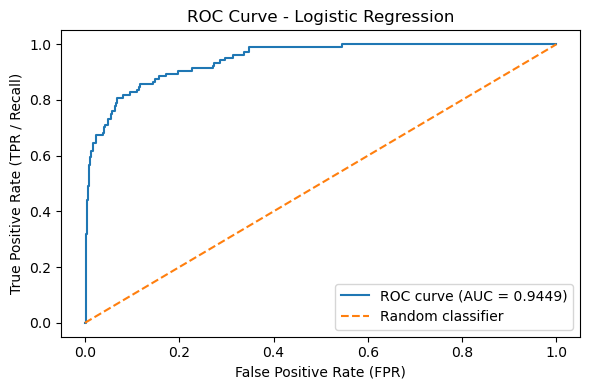

PR-AUC: 0.19833370378437606


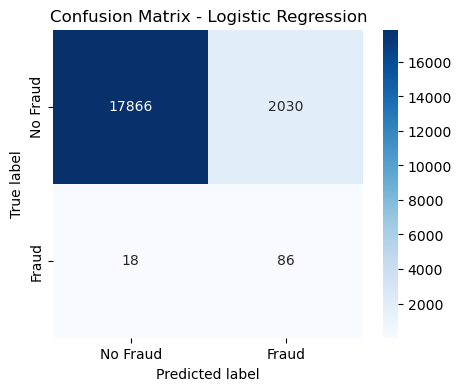

In [20]:
# without grid search cv 
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score
from sklearn.metrics import roc_curve, auc

pipe_non_tree.fit(X_train, y_train)
# Generate class predictions (0 or 1)
# Used for confusion matrix, recall, precision, and F1-score
y_pred = pipe_non_tree.predict(X_test)
# Generate predicted probabilities for the positive class (fraud = 1)
y_proba = pipe_non_tree.predict_proba(X_test)[:, 1]
# Compute recall score
# Recall is critical in fraud detection as it measures
# how many actual fraud cases are correctly identified
print('recall_score', recall_score(y_test, y_pred))
# 

#Print detailed classification report
# Includes precision, recall, F1-score, and support
# Helps understand trade-offs between false positives and false negatives
print(classification_report(y_test, y_pred))

#Compute ROC-AUC score
# Evaluates model’s ability to separate fraud vs non-fraud
# Independent of classification threshold
print("ROC_AUC:", roc_auc_score(y_test, y_proba))

# ROC Curve points
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)

# AUC value (same as roc_auc_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
pr_auc = average_precision_score(y_test, y_proba)
print("PR-AUC:", pr_auc)
# Generate confusion matrix
# Shows True Positives, False Positives, True Negatives, and False Negatives
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix using heatmap
# Makes error distribution easier to interpret
labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
#Label axes for clarity
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#“The model outputs probabilities; the threshold converts probabilities into decisions.”


Final Model @ Threshold = 0.4
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     19896
           1       0.03      0.86      0.06       104

    accuracy                           0.87     20000
   macro avg       0.52      0.86      0.49     20000
weighted avg       0.99      0.87      0.92     20000



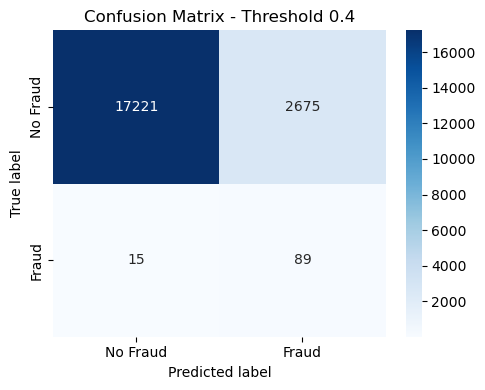

In [21]:
# for different thresold 
chosen_threshold = 0.4
y_pred_final = (y_proba >= chosen_threshold).astype(int)

print("\nFinal Model @ Threshold =", chosen_threshold)
print(classification_report(y_test, y_pred_final))

# Confusion Matrix for final chosen threshold
cm_final = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_final, annot=True, fmt='d', cmap='Blues',
    xticklabels=['No Fraud', 'Fraud'],
    yticklabels=['No Fraud', 'Fraud']
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(f'Confusion Matrix - Threshold {chosen_threshold}')
plt.tight_layout()
plt.show()


Top 20 features by |coefficient|:
                             feature      coef  abs_coef
122                 high_cat__col_43 -4.704762  4.704762
34                 low_cat__state_CT -3.401368  3.401368
24    low_cat__category_shopping_pos -3.161551  3.161551
59                 low_cat__state_NJ -2.809385  2.809385
141                 high_cat__col_62  2.601435  2.601435
23    low_cat__category_shopping_net -2.572257  2.572257
97                  high_cat__col_18 -2.513201  2.513201
110                 high_cat__col_31 -2.046338  2.046338
0                           num__amt  2.010051  2.010051
14   low_cat__category_gas_transport  1.904189  1.904189
95                  high_cat__col_16  1.796005  1.796005
19       low_cat__category_kids_pets  1.703604  1.703604
120                 high_cat__col_41  1.682148  1.682148
61                 low_cat__state_NV -1.668073  1.668073
12   low_cat__category_entertainment -1.663051  1.663051
28                 low_cat__state_AK  1.616978  1.6169

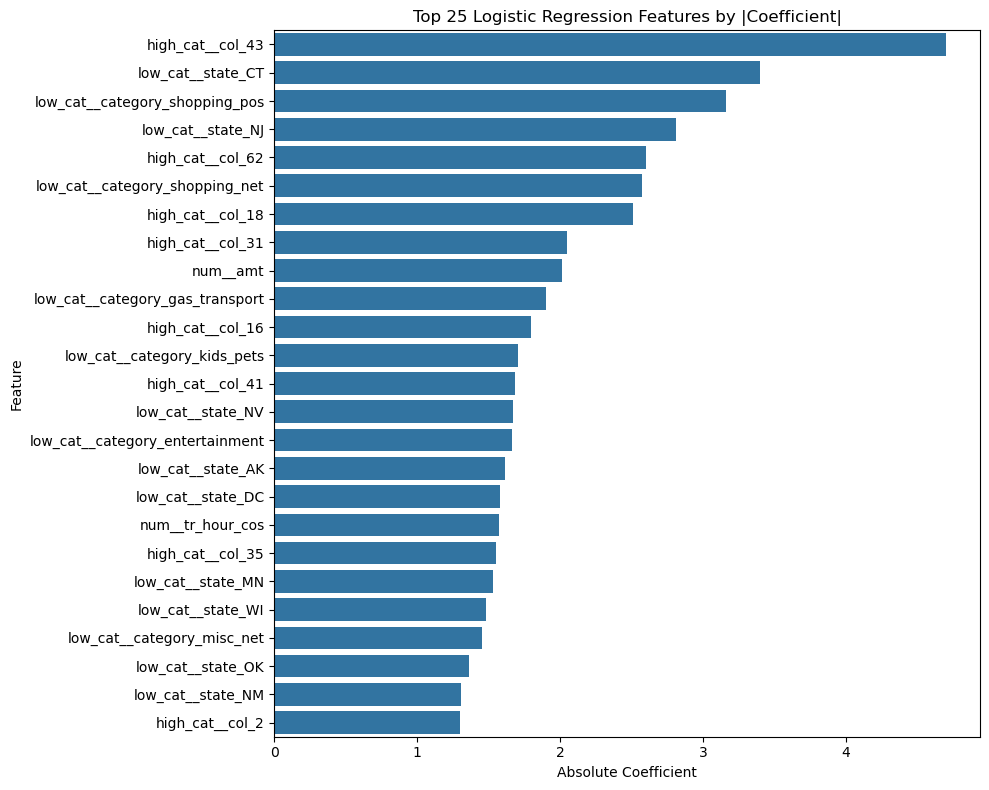

In [22]:
# 1. Take pieces out of the pipeline
preprocess = pipe_non_tree.named_steps['preprocess']
log_model  = pipe_non_tree.named_steps['model']

# 2. Get feature names after preprocessing
feature_names = preprocess.get_feature_names_out()

# 3. Get logistic regression coefficients (binary → shape (1, n_features))
coefs = log_model.coef_.ravel()

# 4. Put into a DataFrame
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
})

# 5. Sort by absolute value (most important first)
coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)

print("Top 20 features by |coefficient|:")
print(coef_df_sorted.head(20))

# 6. Plot bar graph of top N features
top_n = 25
plot_df = coef_df_sorted.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(data=plot_df, x="abs_coef", y="feature")
plt.title(f"Top {top_n} Logistic Regression Features by |Coefficient|")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 7. (Optional) Plot with sign (direction) included
# plt.figure(figsize=(10, 8))
# sns.barplot(data=plot_df, x="coef", y="feature")
# plt.axvline(0, color='black', linewidth=1)
# plt.title(f"Top {top_n} Logistic Regression Features (with sign)")
# plt.xlabel("Coefficient (positive → higher fraud probability)")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()

### Model Training — Tree Models (Decision Tree / Random Forest / XGBoost / LightGBM)

In [23]:
# for tree input pipline 
preprocess_tree = ColumnTransformer(
    transformers=[('num', 'passthrough',all_numeric),
        ('low_cat', low_cat_transformer,  low_card_cat),
        ('high_cat', high_cat_transformer, high_card_cat),],remainder='drop')

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

dt = DecisionTreeClassifier(max_depth=None,criterion='gini',min_samples_split=2,min_samples_leaf=2,class_weight='balanced', random_state=42) #,

dt_pipe = Pipeline(steps=[('preprocess', preprocess_tree),('smote', SMOTE(sampling_strategy=0.10, random_state=42)),('model', dt)])

Decision Tree – classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19896
           1       0.48      0.60      0.53       104

    accuracy                           0.99     20000
   macro avg       0.74      0.80      0.76     20000
weighted avg       1.00      0.99      0.99     20000

Confusion matrix
[[19829    67]
 [   42    62]]
ROC_AUC: 0.79673122351613


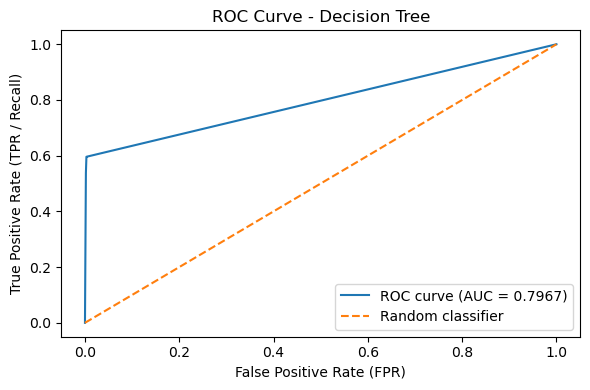

PR-AUC: 0.3503302376102568
recall_score 0.5961538461538461


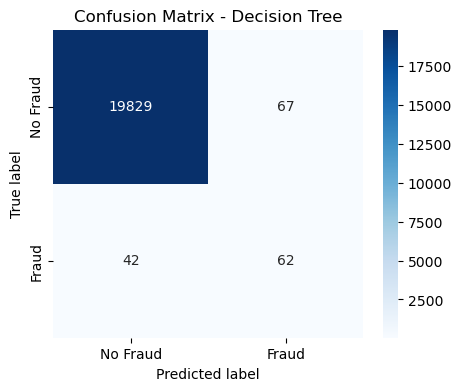

In [25]:
dt_pipe.fit(X_train, y_train)
y_pred_dt  = dt_pipe.predict(X_test)
y_proba_dt = dt_pipe.predict_proba(X_test)[:, 1] 

print("Decision Tree – classification report")
print(classification_report(y_test, y_pred_dt))

print("Confusion matrix")
print(confusion_matrix(y_test, y_pred_dt))

print("ROC_AUC:", roc_auc_score(y_test, y_proba_dt))
# ROC Curve points
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_dt)

# AUC value (same as roc_auc_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
pr_auc = average_precision_score(y_test, y_proba_dt)
print("PR-AUC:", pr_auc)
print('recall_score', recall_score(y_test, y_pred_dt))
cm = confusion_matrix(y_test, y_pred_dt)

labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Decision Tree')
plt.show()



Top 20 features by importance:
                              feature  importance
0                            num__amt    0.640794
14    low_cat__category_gas_transport    0.103177
9                    num__tr_hour_cos    0.088635
19        low_cat__category_kids_pets    0.025906
21         low_cat__category_misc_pos    0.020966
17   low_cat__category_health_fitness    0.015936
103                  high_cat__col_24    0.011966
25           low_cat__category_travel    0.011822
120                  high_cat__col_41    0.010789
84                    high_cat__col_5    0.008524
8                    num__tr_hour_sin    0.007037
22    low_cat__category_personal_care    0.004707
13      low_cat__category_food_dining    0.004163
1                       num__city_pop    0.003844
16      low_cat__category_grocery_pos    0.003531
64                  low_cat__state_OK    0.003385
51                  low_cat__state_MN    0.002981
60                  low_cat__state_NM    0.002958
74                 

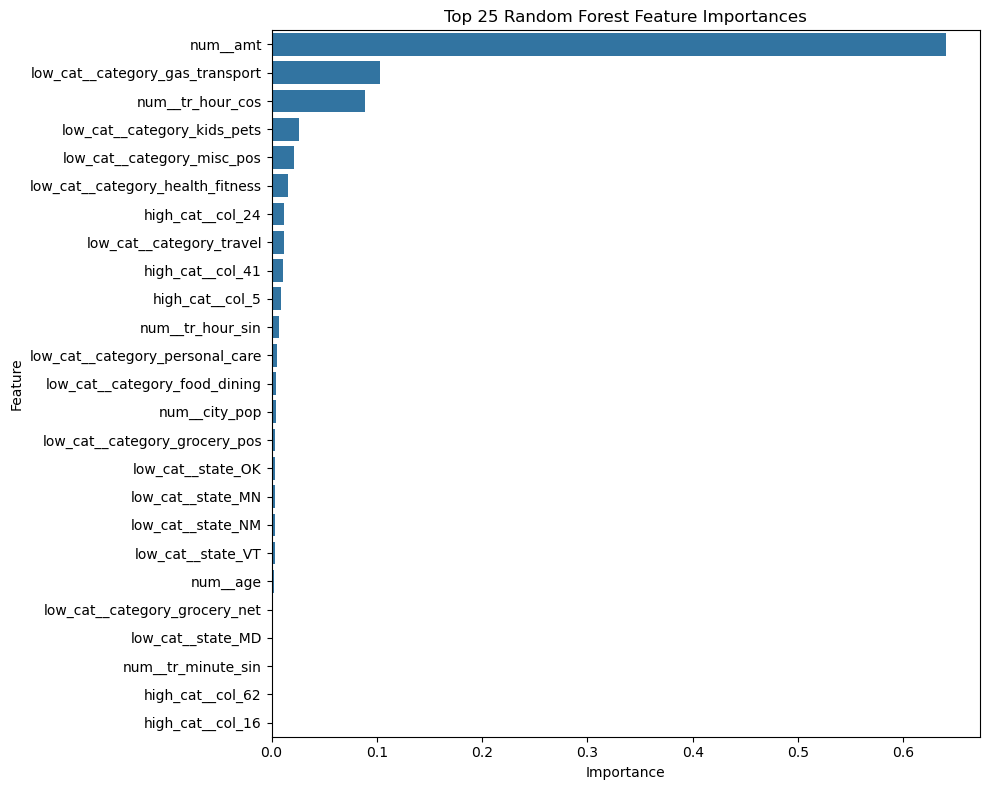

In [26]:
preprocess = dt_pipe.named_steps['preprocess']
dt_model   = dt_pipe.named_steps['model']

# 2. Feature names after preprocessing
feature_names = preprocess.get_feature_names_out()

# 3. Random Forest feature importances
importances = dt_model.feature_importances_

# 4. Put into a dataframe and sort
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("Top 20 features by importance:")
print(fi_df.head(20))

# 5. Plot top N
top_n = 25
plot_df = fi_df.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(data=plot_df, x="importance", y="feature")
plt.title(f"Top {top_n} Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [27]:
# random forest base model without grid serch cv
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42 
)
#('smote', SMOTE(sampling_strategy=0.10, random_state=42)),
rf_pipe = Pipeline(steps=[
    ('preprocess', preprocess_tree),('model', rf)])

=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19896
           1       0.67      0.69      0.68       104

    accuracy                           1.00     20000
   macro avg       0.84      0.85      0.84     20000
weighted avg       1.00      1.00      1.00     20000

ROC_AUC: 0.9809446622436669


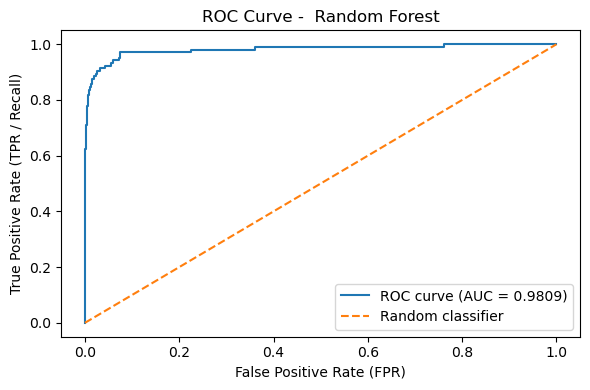

PR-AUC: 0.7205626172649753
Confusion matrix:
 [[19861    35]
 [   32    72]]
recall_score 0.6923076923076923


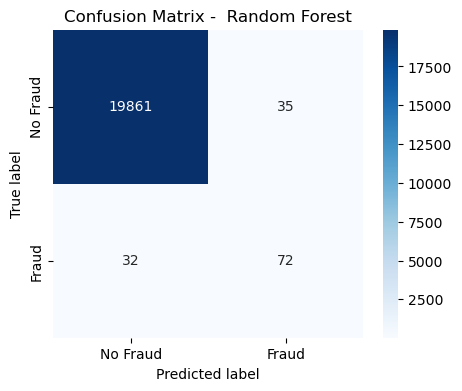

In [28]:
rf_pipe.fit(X_train, y_train)

y_pred_rf  = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC_AUC:", roc_auc_score(y_test, y_proba_rf))
# ROC Curve points
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_rf)

# AUC value (same as roc_auc_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('ROC Curve -  Random Forest')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
pr_auc = average_precision_score(y_test, y_proba_rf)
print("PR-AUC:", pr_auc)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))
print('recall_score', recall_score(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)

labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix -  Random Forest')
plt.show()

Top 20 features by importance:
                            feature  importance
0                          num__amt    0.377397
9                  num__tr_hour_cos    0.148976
8                  num__tr_hour_sin    0.065794
1                     num__city_pop    0.029967
2                          num__age    0.029857
3    num__distance_cust_merchant_km    0.025794
23   low_cat__category_shopping_net    0.022985
10               num__tr_minute_sin    0.020769
11               num__tr_minute_cos    0.020689
4                 num__tr_month_sin    0.019874
5                 num__tr_month_cos    0.014416
6                   num__tr_day_sin    0.012253
14  low_cat__category_gas_transport    0.012108
20       low_cat__category_misc_net    0.011560
7                   num__tr_day_cos    0.010923
16    low_cat__category_grocery_pos    0.010140
13    low_cat__category_food_dining    0.008539
12  low_cat__category_entertainment    0.007324
18           low_cat__category_home    0.007286
22  low_c

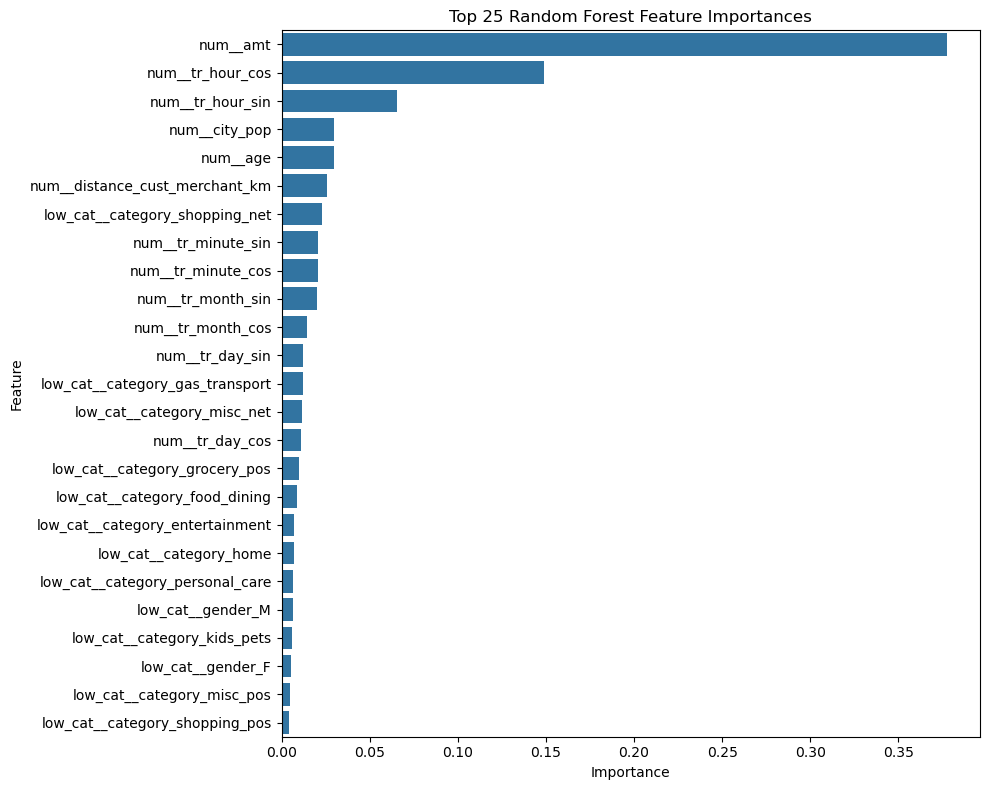

In [29]:
preprocess = rf_pipe.named_steps['preprocess']
rf_model   = rf_pipe.named_steps['model']

# 2. Feature names after preprocessing
feature_names = preprocess.get_feature_names_out()

# 3. Random Forest feature importances
importances = rf_model.feature_importances_

# 4. Put into a dataframe and sort
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("Top 20 features by importance:")
print(fi_df.head(20))

# 5. Plot top N
top_n = 25
plot_df = fi_df.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(data=plot_df, x="importance", y="feature")
plt.title(f"Top {top_n} Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [30]:
#!pip install xgboost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19896
           1       0.83      0.83      0.83       104

    accuracy                           1.00     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       1.00      1.00      1.00     20000

ROC_AUC: 0.9947070922643902


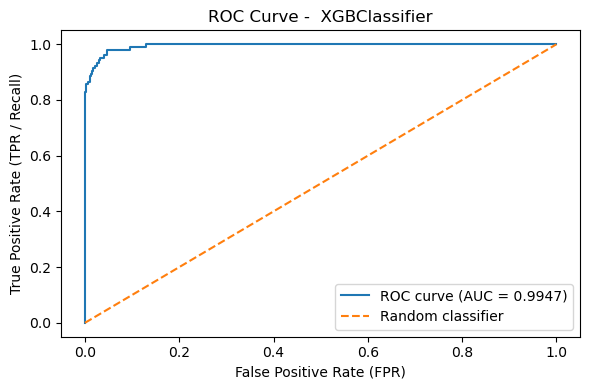

PR-AUC: 0.8582908442920519
Recall: 0.8269230769230769


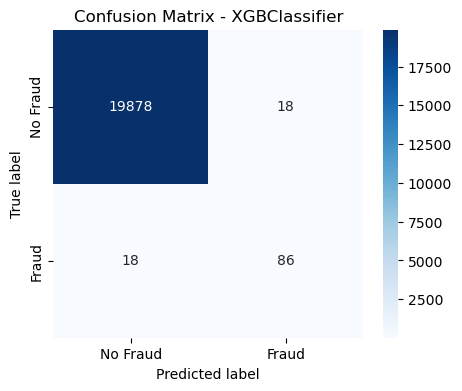

In [31]:
 from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=10,
    random_state=42,
    n_jobs=-1
)
#scale_pos_weight=10,
#('smote', SMOTE(sampling_strategy=0.10, random_state=42)),
xgb_pipe = Pipeline(steps=[
    ('preprocess', preprocess_tree),
    ('model', xgb)
])

xgb_pipe.fit(X_train, y_train)

y_pred_xgb = xgb_pipe.predict(X_test)
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print("ROC_AUC:", roc_auc_score(y_test, y_proba_xgb))
# ROC Curve points
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_xgb)

# AUC value (same as roc_auc_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('ROC Curve -  XGBClassifier')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
pr_auc = average_precision_score(y_test, y_proba_xgb)
print("PR-AUC:", pr_auc)

print("Recall:", recall_score(y_test, y_pred_xgb))
cm = confusion_matrix(y_test, y_pred_xgb)

labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - XGBClassifier')
plt.show()

Top 20 features by importance:
                              feature  importance
0                            num__amt    0.072111
14    low_cat__category_gas_transport    0.048985
9                    num__tr_hour_cos    0.042683
16      low_cat__category_grocery_pos    0.024344
23     low_cat__category_shopping_net    0.024065
25           low_cat__category_travel    0.024021
19        low_cat__category_kids_pets    0.023787
21         low_cat__category_misc_pos    0.021947
18             low_cat__category_home    0.020177
27                  low_cat__gender_M    0.019932
20         low_cat__category_misc_net    0.019839
12    low_cat__category_entertainment    0.014870
8                    num__tr_hour_sin    0.014772
58                  low_cat__state_NH    0.014030
133                  high_cat__col_54    0.013102
15      low_cat__category_grocery_net    0.012869
17   low_cat__category_health_fitness    0.012775
13      low_cat__category_food_dining    0.012218
94                 

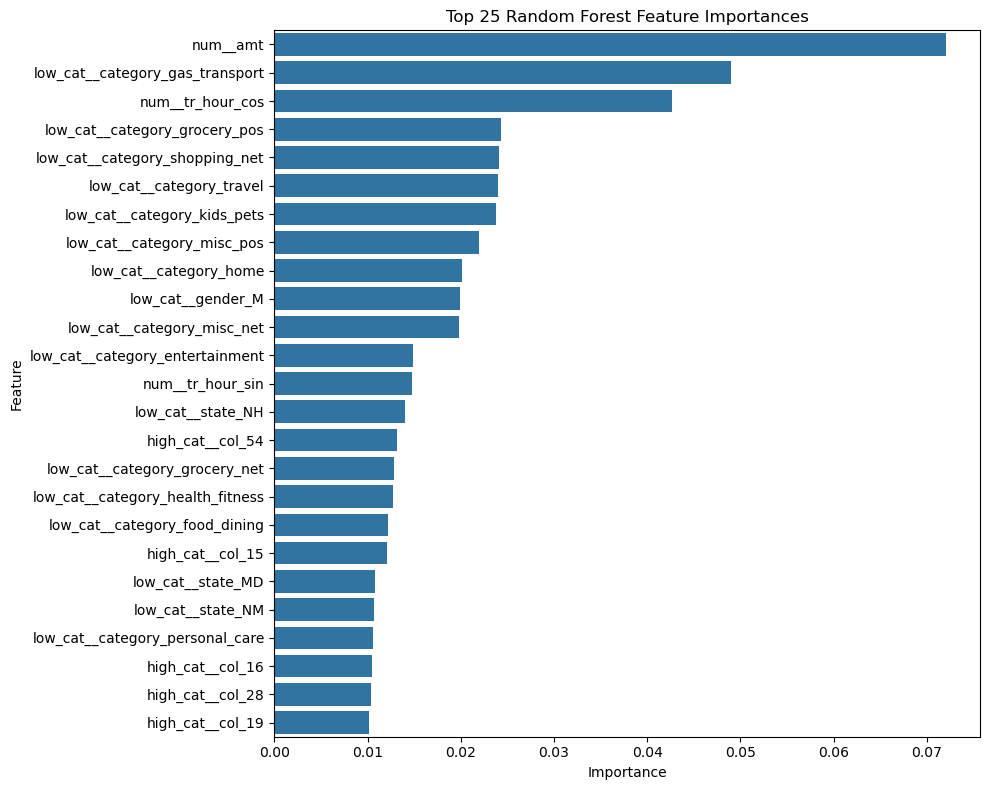

In [32]:
preprocess =xgb_pipe.named_steps['preprocess']
xgb_model   = xgb_pipe.named_steps['model']

# 2. Feature names after preprocessing
feature_names = preprocess.get_feature_names_out()

# 3. Random Forest feature importances
importances = xgb_model.feature_importances_

# 4. Put into a dataframe and sort
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("Top 20 features by importance:")
print(fi_df.head(20))

# 5. Plot top N
top_n = 25
plot_df = fi_df.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(data=plot_df, x="importance", y="feature")
plt.title(f"Top {top_n} Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

[LightGBM] [Info] Number of positive: 417, number of negative: 79583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1267
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 142
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\patid\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\patid\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== LightGBM ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19896
           1       0.88      0.81      0.84       104

    accuracy                           1.00     20000
   macro avg       0.94      0.90      0.92     20000
weighted avg       1.00      1.00      1.00     20000

ROC_AUC: 0.9944354876125081


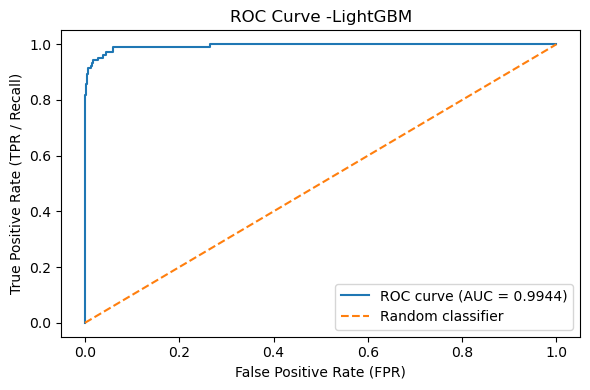

PR-AUC: 0.8777070899191302
Recall: 0.8076923076923077


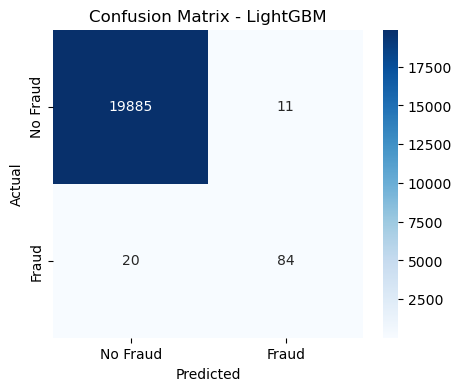

In [33]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ----- class weight for imbalance -----
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# ----- LightGBM Model -----
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,               # LightGBM ignores if -1
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',    # handles imbalance
    random_state=42,
    n_jobs=-1
)

# ----- Pipeline -----
lgbm_pipe = Pipeline(steps=[
    ('preprocess', preprocess_tree),
    ('model', lgbm)
])

# ----- Fit -----
lgbm_pipe.fit(X_train, y_train)

# ----- Predictions -----
y_pred_lgb  = lgbm_pipe.predict(X_test)
y_proba_lgb = lgbm_pipe.predict_proba(X_test)[:, 1]

print("=== LightGBM ===")
print(classification_report(y_test, y_pred_lgb))
print("ROC_AUC:", roc_auc_score(y_test, y_proba_lgb))
# ROC Curve points
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_lgb)

# AUC value (same as roc_auc_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('ROC Curve -LightGBM')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
pr_auc = average_precision_score(y_test, y_proba_lgb)
print("PR-AUC:", pr_auc)

print("Recall:", recall_score(y_test, y_pred_lgb))

# ----- Confusion matrix -----
cm = confusion_matrix(y_test, y_pred_lgb)

labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LightGBM')
plt.show()

Top 20 LightGBM Features:
                            feature  importance
0                          num__amt        3699
1                     num__city_pop        2853
2                          num__age        2719
3    num__distance_cust_merchant_km        2395
11               num__tr_minute_cos        1639
10               num__tr_minute_sin        1636
8                  num__tr_hour_sin        1445
9                  num__tr_hour_cos        1234
4                 num__tr_month_sin        1002
5                 num__tr_month_cos         986
6                   num__tr_day_sin         761
16    low_cat__category_grocery_pos         455
26                low_cat__gender_F         402
7                   num__tr_day_cos         378
23   low_cat__category_shopping_net         370
24   low_cat__category_shopping_pos         365
14  low_cat__category_gas_transport         356
20       low_cat__category_misc_net         348
21       low_cat__category_misc_pos         326
18           l

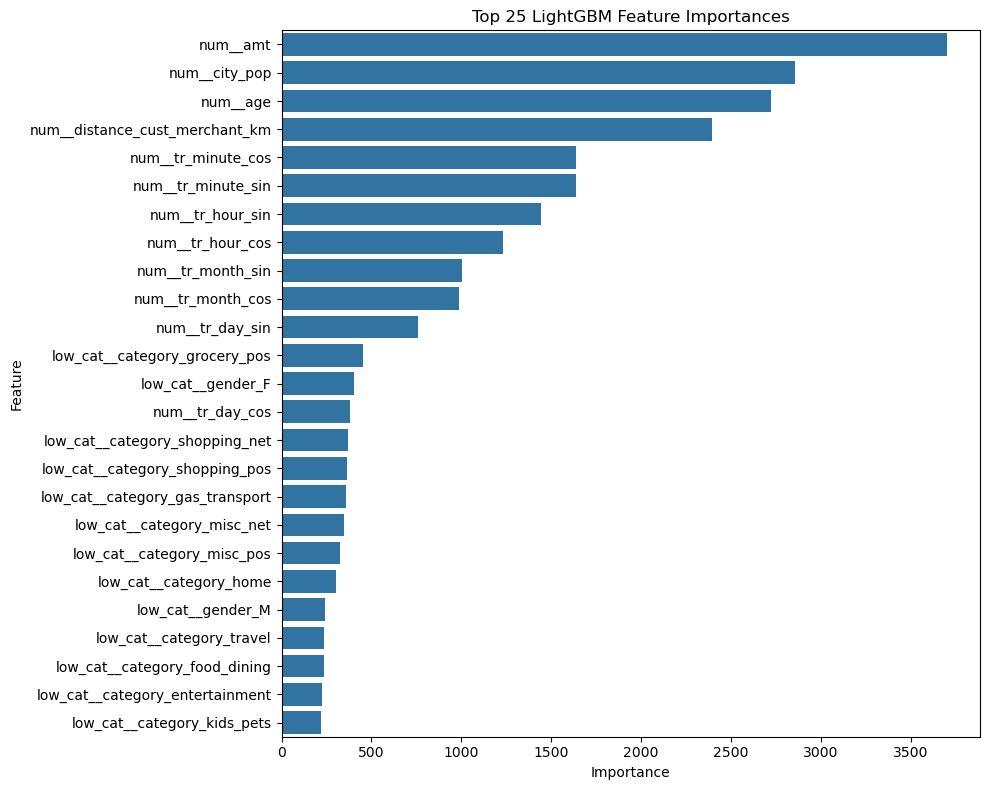

In [34]:
# =====================
#   FEATURE IMPORTANCE
# =====================
preprocess = lgbm_pipe.named_steps['preprocess']
lgbm_model = lgbm_pipe.named_steps['model']

# 1. Feature names after preprocessing
feature_names = preprocess.get_feature_names_out()

# 2. LightGBM feature importances
importances = lgbm_model.feature_importances_

# 3. Create DF
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("Top 20 LightGBM Features:")
print(fi_df.head(20))

# ----- Plot top N -----
top_n = 25
plot_df = fi_df.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(data=plot_df, x="importance", y="feature")
plt.title(f"Top {top_n} LightGBM Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [35]:
# example names – adjust to what you actually used

recall_log_reg   = recall_score(y_test, y_pred)
recall_dt        = recall_score(y_test, y_pred_dt)
recall_rf        = recall_score(y_test, y_pred_rf)
recall_xgb       = recall_score(y_test, y_pred_xgb)
recall_lgbm      = recall_score(y_test, y_pred_lgb)   # LightGBM
# if you have tuned models (grid/random) you can add them too:
# recall_rf_grid   = recall_score(y_test, y_pred_rf_grid)
# recall_xgb_rand  = recall_score(y_test, y_pred_xgb_r)

                 model    recall
0  Logistic Regression  0.826923
1        Decision Tree  0.596154
2        Random Forest  0.692308
3              XGBoost  0.826923
4             LightGBM  0.807692


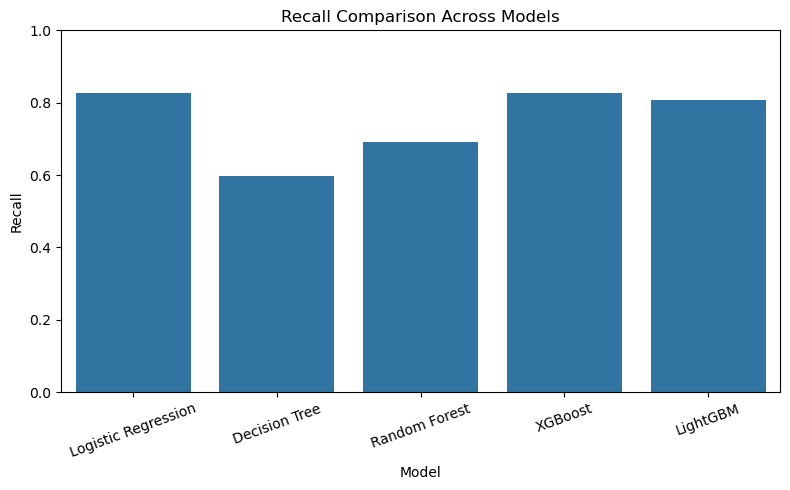

In [36]:
recall_data = {
    "model": [ "Logistic Regression", "Decision Tree", "Random Forest", "XGBoost","LightGBM"],
    "recall": [ recall_log_reg, recall_dt, recall_rf,recall_xgb,recall_lgbm]
}

recall_df = pd.DataFrame(recall_data)

print(recall_df)

# bar plot
plt.figure(figsize=(8, 5))
sns.barplot(data=recall_df, x="model", y="recall")

plt.ylim(0, 1)  # recall is between 0 and 1
plt.title("Recall Comparison Across Models")
plt.ylabel("Recall")
plt.xlabel("Model")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
threshold = 0.20
# y_pred_lgb  = lgbm_pipe.predict(X_test)
# y_proba_lgb = lgbm_pipe.predict_proba(X_test)[:, 1]

y_pred = (y_proba_lgb >= threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Threshold:", threshold)
print("Fraud Recall (catch rate):", recall_score(y_test, y_pred))
print("Fraud Precision:", precision_score(y_test,y_pred))
print("Fraud F1:", f1_score(y_test, y_pred))
print("TP (fraud caught):", tp)
print("FN (fraud missed):", fn)
print("FP (false alerts):", fp)
print("Alert rate:", (tp+fp)/len(y_test))

Threshold: 0.2
Fraud Recall (catch rate): 0.8173076923076923
Fraud Precision: 0.8333333333333334
Fraud F1: 0.8252427184466019
TP (fraud caught): 85
FN (fraud missed): 19
FP (false alerts): 17
Alert rate: 0.0051


At a threshold of 0.2, the model prioritizes fraud detection, achieving ~82% recall while maintaining high precision (~83%) and a low alert rate (0.51%), making it suitable for real-world fraud monitoring.

In [38]:
#model comparison table (default threshold = 0.5)
model_comparison = pd.DataFrame({
    "Model": ["Logistic Regression + SMOTE","Decision Tree + SMOTE", "Random Forest + SMOTE","XGBoost","LightGBM"],
    "Fraud Precision": [0.04,0.48,0.67,0.83,0.88],
    "Fraud Recall": [0.83,0.60,0.69,0.83,0.81],
    "Fraud F1": [0.08,0.53,0.68,0.83,0.84],
    "ROC-AUC": [0.94,0.80,0.98,0.99,0.99],
    "PR-AUC": [0.20,0.35,0.72,0.86,0.88],
    "Interpretation": [
        "High recall, unusable precision",
        "Overfitting, unstable",
        "Strong baseline",
        "Excellent performance",
        "Best overall" ]
})
model_comparison

,Model,Fraud Precision,Fraud Recall,Fraud F1,ROC-AUC,PR-AUC,Interpretation
0,Logistic Regression + SMOTE,0.04,0.83,0.08,0.94,0.20,"High recall, unusable precision"
1,Decision Tree + SMOTE,0.48,0.60,0.53,0.80,0.35,"Overfitting, unstable"
2,Random Forest + SMOTE,0.67,0.69,0.68,0.98,0.72,Strong baseline
3,XGBoost,0.83,0.83,0.83,0.99,0.86,Excellent performance
4,LightGBM,0.88,0.81,0.84,0.99,0.88,Best overall


In [39]:
model_comparison.style.format({
    "Fraud Precision": "{:.2f}",
    "Fraud Recall": "{:.2f}",
    "Fraud F1": "{:.2f}",
    "ROC-AUC": "{:.2f}",
    "PR-AUC": "{:.2f}"
})

,Model,Fraud Precision,Fraud Recall,Fraud F1,ROC-AUC,PR-AUC,Interpretation
0,Logistic Regression + SMOTE,0.04,0.83,0.08,0.94,0.20,"High recall, unusable precision"
1,Decision Tree + SMOTE,0.48,0.60,0.53,0.80,0.35,"Overfitting, unstable"
2,Random Forest + SMOTE,0.67,0.69,0.68,0.98,0.72,Strong baseline
3,XGBoost,0.83,0.83,0.83,0.99,0.86,Excellent performance
4,LightGBM,0.88,0.81,0.84,0.99,0.88,Best overall


In [40]:
model_comparison.sort_values("PR-AUC", ascending=False)

,Model,Fraud Precision,Fraud Recall,Fraud F1,ROC-AUC,PR-AUC,Interpretation
4,LightGBM,0.88,0.81,0.84,0.99,0.88,Best overall
3,XGBoost,0.83,0.83,0.83,0.99,0.86,Excellent performance
2,Random Forest + SMOTE,0.67,0.69,0.68,0.98,0.72,Strong baseline
1,Decision Tree + SMOTE,0.48,0.60,0.53,0.80,0.35,"Overfitting, unstable"
0,Logistic Regression + SMOTE,0.04,0.83,0.08,0.94,0.20,"High recall, unusable precision"
